# AdEx - thalamus loop investigation

after fixing the model parameters analyse the results:
* basic timeseries plots
* spectral characteristics
* spindle detection
* SW detection
* phase-phase measures
* phase-amplitude measures

In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import yasa
from analysis.plotting import (
    plot_average_events_ts,
    plot_average_events_wavelet,
    plot_circular_histogram,
    plot_kullback_leibler_modulation_index,
    plot_mean_vector_length,
    plot_phase_locking_value,
)
from analysis.routines import XFreqEvaluateSignal
from analysis.shannon import mutual_information
from analysis.spindles import (
    _multiproc_func_filter_spindles,
    filter_cortical_spindles_with_thalamic,
    spindles_detect_adex,
    spindles_detect_thalamus,
)
from analysis.x_freq import (
    kullback_leibler_modulation_index,
    mean_vector_length,
    phase_locking_value,
)
from custom_models.adex_thalamus_old import (
    DEFAULT_ADEX_NODE_CONNECTIVITY,
    DEFAULT_ADEX_NODE_DELAYS,
    DEFAULT_PARAMS_EXC,
    DEFAULT_PARAMS_INH,
    DEFAULT_PARAMS_TCR,
    DEFAULT_PARAMS_TRN,
    DEFAULT_THALAMIC_CONNECTIVITY,
    AdExThalamusMiniNetwork,
)
from models.model_input import OrnsteinUhlenbeckProcess, ZeroInput
from neuro_signal import RatesSignal
from neuro_signal.routines import get_amplitude, get_phase
from statistical_testing.p_values import get_p_values
from statistical_testing.plotting import plot_surr_vs_data_hist
from tools.plotting import plot_spectrum, plot_timeseries
from yasa import get_centered_indices, stft_power

DPI = 75
CMAP = "plasma"
plt.rcParams["figure.figsize"] = (20, 9)
plt.rcParams["font.size"] = 18
plt.style.use("default_light")

In [2]:
POLAR_XTICKLABELS = [r"$-\pi$ = $\pi$", r"$-\pi/2$", "0", r"$\pi/2$", r"$\pi$"]
DELAY = 13.0  # ms
DURATION = 90000  # ms
OU_TAU = 5.0  # ms
DT = 0.005  # ms
T_SPIN_UP = 5000  # ms
SW = {"low_freq": 0.1, "high_freq": 3.0}
SP = {"low_freq": 11.0, "high_freq": 16.0}


def conditional_means_plot(
    phase, second_ts, xlabel, ylabel, second_phase=False, bins=36
):
    phase_bin_edges = np.linspace(phase.min(), phase.max(), bins + 1)
    phase_bins = np.digitize(phase, phase_bin_edges) - 1
    if second_phase:
        histogram = np.array(
            [
                sts.circmean(second_ts[phase_bins == i], low=-np.pi, high=np.pi)
                for i in range(bins)
            ]
        )
    else:
        histogram = np.array([np.mean(second_ts[phase_bins == i]) for i in range(bins)])
        histogram /= np.sum(histogram)
    plt.bar(phase_bin_edges[:-1], histogram, align="edge")
    plt.gca().set_xticks(np.linspace(-np.pi, np.pi, 5))
    plt.gca().set_xticklabels(POLAR_XTICKLABELS)
    if second_phase:
        plt.gca().set_yticks(np.linspace(-np.pi, np.pi, 5))
        plt.gca().set_yticklabels(POLAR_XTICKLABELS)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def simulate_net(
    ad_th, th_ad, ou_exc_mu, ou_inh_mu, aln_sigma=0.0, tcr_sigma=0.0, tauA=200.0, b=40.0
):
    # init model
    adex_thalamus = AdExThalamusMiniNetwork(
        connectivity_matrix=np.array(
            [
                [0.0, ad_th],
                [th_ad, 0.0],
            ]
        ),
        delay_matrix=np.array(
            [
                [0.0, DELAY],
                [DELAY, 0.0],
            ]
        ),
        thalamus_params=[
            {**DEFAULT_PARAMS_TCR, "g_LK": 0.032},
            {**DEFAULT_PARAMS_TRN, "g_LK": 0.032},
            DEFAULT_THALAMIC_CONNECTIVITY,
        ],
        adex_params=[
            {**DEFAULT_PARAMS_EXC, "tau_A": tauA, "b": b, "a": 0.0},
            DEFAULT_PARAMS_INH,
            DEFAULT_ADEX_NODE_CONNECTIVITY,
            DEFAULT_ADEX_NODE_DELAYS,
        ],
    )
    # model input - noise
    adex_exc = OrnsteinUhlenbeckProcess(
        DURATION + T_SPIN_UP,
        DT,
        mu=ou_exc_mu,
        sigma=aln_sigma,
        tau=OU_TAU,
    ).as_array()
    adex_inh = OrnsteinUhlenbeckProcess(
        DURATION + T_SPIN_UP,
        DT,
        mu=ou_inh_mu,
        sigma=aln_sigma,
        tau=OU_TAU,
    ).as_array()
    thalamus_exc = OrnsteinUhlenbeckProcess(
        DURATION + T_SPIN_UP,
        DT,
        mu=0.0,
        sigma=tcr_sigma,
        tau=OU_TAU,
    ).as_array()
    thalamus_inh = ZeroInput(DURATION + T_SPIN_UP, DT).as_array()
    results = adex_thalamus.run(
        duration=DURATION,
        sampling_dt=1.0,
        dt=DT,
        noise_input=np.hstack([adex_exc, adex_inh, thalamus_exc, thalamus_inh]),
        time_spin_up=T_SPIN_UP,
        backend="numba",
    )
    aln = results["q_mean_EXC"].isel({"node": 0}) * 1000.0
    tcr = results["q_mean_EXC"].isel({"node": 1}) * 1000.0

    return pd.DataFrame({"ALN": aln.values, "TCR": tcr.values}, index=results.time)


def so_phase(signal):
    return get_phase(signal, filter_args=SW, pad=5.0)


def spindle_phase(signal):
    return get_phase(signal, filter_args=SP, pad=5.0)


def spindle_amp(signal):
    return get_amplitude(signal, filter_args=SP, pad=5.0)


dkmi = XFreqEvaluateSignal(
    measure_function=kullback_leibler_modulation_index,
    slow_timeseries_preprocessing=so_phase,
    fast_timeseries_preprocessing=spindle_amp,
    measure_settings={"bins": 36, "return_for_plotting": True},
    surrogate_settings={"num_surr": 1000, "surrogate_type": "FT"},
)

mvl = XFreqEvaluateSignal(
    measure_function=lambda x, y: np.abs(mean_vector_length(x, y)),
    slow_timeseries_preprocessing=so_phase,
    fast_timeseries_preprocessing=spindle_amp,
    measure_settings={},
    surrogate_settings={"num_surr": 1000, "surrogate_type": "FT"},
)

plv = XFreqEvaluateSignal(
    measure_function=lambda x, y, n, m: np.abs(phase_locking_value(x, y, n, m)),
    slow_timeseries_preprocessing=so_phase,
    fast_timeseries_preprocessing=spindle_phase,
    measure_settings={"n": 1, "m": 1},
    surrogate_settings={"num_surr": 1000, "surrogate_type": "FT"},
)

mi_eqq = XFreqEvaluateSignal(
    measure_function=mutual_information,
    slow_timeseries_preprocessing=so_phase,
    fast_timeseries_preprocessing=spindle_phase,
    measure_settings={"algorithm": "EQQ", "bins": 16},
    surrogate_settings={"num_surr": 1000, "surrogate_type": "FT"},
)

In [ ]:
params = [(3.1, "right_border")]  # , (2.25, "left_border"), (2.4, "inside_lc")]
titles = {
    "right_border": r"Border $\mathregular{{LC_{{aE}}}}$ $\times$ up",
    "left_border": r"Border down $\times$ $\mathregular{{LC_{{aE}}}}$",
    "inside_lc": "Inside $\mathregular{{LC_{{aE}}}}$",
}
# prepare
SPINDLE_DURATION = (0.15, 2.0)
REL_POWER_ALN = 0.05
BEFORE = 1.0
AFTER = 1.0

for exc_inp, plot_name in params:

    # simulte network
    results_df = simulate_net(
        ad_th=1.0,
        th_ad=0.15,
        ou_exc_mu=exc_inp,
        ou_inh_mu=3.5,
        aln_sigma=0.05,
        tcr_sigma=0.005,
        tauA=1000.0,
        b=15.0,
    )

    # get phase and amplitude timeseries
    aln_xr = xr.DataArray(results_df["ALN"])
    tcr_xr = xr.DataArray(results_df["TCR"])
    sf = float(1.0 / (aln_xr.time[1] - aln_xr.time[0]))
    aln_sig = RatesSignal(aln_xr)
    tcr_sig = RatesSignal(tcr_xr)
    aln_sw_phase = get_phase(aln_sig, filter_args=SW, pad=5.0)
    aln_sw_amp = get_amplitude(aln_sig, filter_args=SW, pad=5.0)
    aln_sp_phase = get_phase(aln_sig, filter_args=SP, pad=5.0)
    aln_sp_amp = get_amplitude(aln_sig, filter_args=SP, pad=5.0)
    tcr_sp_phase = get_phase(tcr_sig, filter_args=SP, pad=5.0)
    tcr_sp_amp = get_amplitude(tcr_sig, filter_args=SP, pad=5.0)

    fig, axs = plt.subplots(
        nrows=4, ncols=2, sharex="col", sharey="row", figsize=(20, 9)
    )

    # timeseries plot ALN
    ax = axs[0, 0]
    ax.plot(results_df.index, results_df["ALN"], color="k", linewidth=1.5)
    res = spindles_detect_adex(
        xr.DataArray(results_df["ALN"]),
        duration=SPINDLE_DURATION,
        rel_power=REL_POWER_ALN,
    )
    if res is not None:
        spindles_highlight = results_df["ALN"] * res.get_mask()
        spindles_highlight[spindles_highlight == 0] = np.nan
        ax.plot(results_df.index, spindles_highlight, color="indianred", linewidth=1.5)
    ax.set_ylabel("ALN r [Hz]")
    ax.set_ylim([0, 40])
    ax.set_yticks([0, 20, 40])
    ax.set_xlim([15, 35])
    sns.despine(trim=True, ax=ax)

    sw_setting = {
        "freq_sw": (0.2, 3.0),
        "amp_neg": (-0.5, 30.0),
        "amp_pos": (1.0, 70.0),
        "amp_ptp": (7.5, 70.0),
        "dur_neg": (0.1, 2.0),
        "dur_pos": (0.05, 1.0),
        "coupling": True,
        "freq_sp": tuple(SP.values()),
    }

    aln_sw = yasa.sw_detect(aln_xr, sf=sf, **sw_setting)
    if aln_sw is not None:
        so_phases = aln_sw.summary()["PhaseAtSigmaPeak"].dropna()

    # timeseries plot TCR
    ax = axs[2, 0]
    ax.plot(results_df.index, results_df["TCR"], color="k", linewidth=1.5)
    res = spindles_detect_thalamus(
        xr.DataArray(results_df["TCR"]), duration=SPINDLE_DURATION
    )
    spindles_highlight = results_df["TCR"] * res.get_mask()
    spindles_highlight[spindles_highlight == 0] = np.nan
    ax.plot(results_df.index, spindles_highlight, color="indianred", linewidth=1.5)
    ax.set_ylabel("TCR r [Hz]")
    ax.set_ylim([0, 400])
    ax.set_yticks([0, 200, 400])
    ax.set_xlim([15, 35])
    sns.despine(trim=True, ax=ax)

    # TFR plot ALN and TCR
    sampling_freq = 1.0 / (results_df.index[1] - results_df.index[0])
    window = 2.0  # seconds
    step = 0.2  # seconds
    freqs_bounds = (0.1, 20.0)
    vmin = 0.0
    vmax = 0.25
    for ii, node in enumerate(["ALN", "TCR"]):
        f, _, Sxx = stft_power(
            results_df[node],
            sampling_freq,
            window=window,
            step=step,
            band=freqs_bounds,
            norm=True,
            interp=True,
        )
        ax = axs[2 * ii + 1, 0]
        ax.pcolormesh(
            results_df.index, f, Sxx, cmap=CMAP, vmin=vmin, vmax=vmax, rasterized=True
        )
        ax.grid()
        ax.set_ylabel(f"{node} f [Hz]")
        sns.despine(trim=True, ax=ax)
        ax.set_xlim([15, 35])
    axs[-1, 0].set_xlabel("time [sec]")
    cbar_ax = fig.add_axes([0.2, 0.0, 0.2, 0.02])
    cbar = mpl.colorbar.ColorbarBase(
        cbar_ax,
        cmap=plt.get_cmap(CMAP),
        norm=mpl.colors.Normalize(vmin=vmin, vmax=vmax),
        orientation="horizontal",
        extend="max",
    )
    cbar.set_label("power Hz$^{2}$/Hz")

    # spindles
    sp_adex = spindles_detect_adex(
        aln_xr, duration=SPINDLE_DURATION, rel_power=REL_POWER_ALN
    ).summary()
    sp_tcr = spindles_detect_thalamus(tcr_xr, duration=SPINDLE_DURATION).summary()
    tcr_idx, _ = get_centered_indices(
        tcr_xr.values,
        (sp_tcr["Peak"] * sf).astype(int).to_numpy(),
        int(BEFORE * sf),
        int(AFTER * sf),
    )

    # average spindle ALN
    ax = axs[0, 1]
    plot_average_events_ts(
        aln_xr,
        events_idx=tcr_idx,
        time_before=BEFORE,
        time_after=AFTER,
        color="indianred",
        ylabel="",
        title="",
        second_ts=tcr_xr,
        color_second_ts="k",
        ax=ax,
    )
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylim([0, 40])
    sns.despine(trim=True, ax=ax)
    sns.despine(trim=True, ax=plt.gca())
    plt.gca().set_yticks([])

    ax = axs[1, 1]
    plot_average_events_wavelet(
        aln_xr,
        events_idx=tcr_idx,
        time_before=BEFORE,
        time_after=AFTER,
        freqs_bounds=freqs_bounds,
        cmap=CMAP,
        title="",
        additional_ts={
            "TCR spindle envelope": tcr_sp_amp.data.values,
            "EXC spindle envelope": aln_sp_amp.data.values,
            "EXC slow wave envelope": aln_sw_amp.data.values,
        },
        additional_ts_colors=["yellow", "w", "lime"],
        ax=ax,
        rasterized=True,
    )
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.gca().get_legend().remove()

    # average spindle TCR
    ax = axs[2, 1]
    plot_average_events_ts(
        tcr_xr,
        events_idx=tcr_idx,
        time_before=BEFORE,
        time_after=AFTER,
        color="indianred",
        ylabel="",
        title="",
        second_ts=aln_xr,
        color_second_ts="k",
        ax=ax,
    )
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylim([0, 400])
    sns.despine(trim=True, ax=ax)
    sns.despine(trim=True, ax=plt.gca())
    plt.gca().set_yticks([])

    ax = axs[3, 1]
    lines = plot_average_events_wavelet(
        tcr_xr,
        events_idx=tcr_idx,
        time_before=BEFORE,
        time_after=AFTER,
        freqs_bounds=freqs_bounds,
        cmap=CMAP,
        title="SPINDLES / TCR",
        additional_ts={
            "TCR spindle envelope": tcr_sp_amp.data.values,
            "EXC spindle envelope": aln_sp_amp.data.values,
            "EXC slow wave envelope": aln_sw_amp.data.values,
        },
        additional_ts_colors=["yellow", "w", "lime"],
        ax=ax,
        return_legend_handler=True,
        rasterized=True,
    )
    ax.set_title("")
    ax.set_ylabel("")
    ax.set_xlabel("time w.r.t TCR spindle peak [sec]")
    plt.gca().get_legend().remove()

    fig.legend(
        lines,
        ("TCR spindle envelope", "EXC spindle envelope", "EXC slow wave envelope"),
        loc="upper center",
        bbox_to_anchor=(0.74, 0.035),
        bbox_transform=fig.transFigure,
    )

    ax = fig.add_axes([0.48, 0.75, 0.08, 0.08], projection="polar")
    plot_circular_histogram(so_phases, ax=ax)
    plt.suptitle(
        titles[plot_name]
        + f"\n$\mu_{{E}}={exc_inp / 5.0:.3f}$ nA, $\mu_{{I}}={3.5 / 5.0:.3f}$ nA"
    )

    plt.text(
        0.07,
        0.92,
        "A",
        ha="center",
        va="center",
        transform=fig.transFigure,
        fontsize=40,
    )
    plt.text(
        0.9,
        0.92,
        "B",
        ha="center",
        va="center",
        transform=fig.transFigure,
        fontsize=40,
    )
    # to PDF due transparency
    plt.savefig(
        f"../figs/loop_spindles_{plot_name}.pdf", transparent=True, bbox_inches="tight"
    )

    # phase-amplitude CFC
    plt.rcParams["figure.figsize"] = (12, 5.4)
    dkmi_data, dkmi_surrs = dkmi.run(slow_timeseries=aln_sig, fast_timeseries=tcr_sig)
    surrs_values = np.array([surr_result[0] for surr_result in dkmi_surrs])
    p_val = get_p_values(dkmi_data[0], surrs_values, tailed="upper")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plot_kullback_leibler_modulation_index(
        dkmi_data,
        dkmi_surrs,
        ax=ax,
        data_color="C0",
        surr_color="C1",
        perc_color="C1",
    )
    sns.despine(trim=True)
    ax.set_xlabel("ALN slow wave phase")
    ax.set_ylabel("TCR spindle amplitude")
    ax.set_title(f"KL-MI value in data: {dkmi_data[0]:.4f}")
    plt.savefig(
        f"../figs/KLMI_aln_tcr_{plot_name}.pdf", transparent=True, bbox_inches="tight"
    )

    plot_surr_vs_data_hist(surrs_values, dkmi_data[0], measure_name="KL-MI")
    plt.title("1000 FT surrogates: p-val < 1e-3")
    sns.despine(trim=True)
    plt.savefig(
        f"../figs/KLMI_aln_tcr_pval_{plot_name}.pdf",
        transparent=True,
        bbox_inches="tight",
    )

    mvl_data, mvl_surrs = mvl.run(slow_timeseries=aln_sig, fast_timeseries=tcr_sig)
    p_val = get_p_values(mvl_data, mvl_surrs, tailed="upper")
    plot_mean_vector_length(
        aln_sw_phase.data.values, tcr_sp_amp.data.values, rasterized=True
    )
    plt.savefig(
        f"../figs/mvl_aln_tcr_{plot_name}.pdf", transparent=True, bbox_inches="tight"
    )
    plot_surr_vs_data_hist(mvl_surrs, mvl_data, measure_name="MVL")
    sns.despine(trim=True)
    plt.title("1000 FT surrogates: p-val < 1e-3")
    plt.savefig(
        f"../figs/mvl_aln_tcr_pval_{plot_name}.pdf",
        transparent=True,
        bbox_inches="tight",
    )

    dkmi_data, dkmi_surrs = dkmi.run(slow_timeseries=aln_sig, fast_timeseries=aln_sig)
    surrs_values = np.array([surr_result[0] for surr_result in dkmi_surrs])
    p_val = get_p_values(dkmi_data[0], surrs_values, tailed="upper")
    plot_kullback_leibler_modulation_index(
        dkmi_data,
        dkmi_surrs,
        ax=None,
        data_color="C0",
        surr_color="w",
        perc_color="C1",
    )
    sns.despine(trim=True)
    plt.gca().set_xlabel("ALN slow wave phase")
    plt.gca().set_ylabel("ALN spindle amplitude")
    plt.gca().set_title(f"KL-MI value in data: {dkmi_data[0]:.4f}")
    plt.savefig(
        f"../figs/KLMI_aln_aln_{plot_name}.pdf", transparent=True, bbox_inches="tight"
    )

    plot_surr_vs_data_hist(surrs_values, dkmi_data[0], measure_name="KL-MI")
    plt.title("1000 FT surrogates: p-val < 1e-3")
    sns.despine(trim=True)
    plt.savefig(
        f"../figs/KLMI_aln_aln_pval_{plot_name}.pdf",
        transparent=True,
        bbox_inches="tight",
    )

    mvl_data, mvl_surrs = mvl.run(slow_timeseries=aln_sig, fast_timeseries=aln_sig)
    p_val = get_p_values(mvl_data, mvl_surrs, tailed="upper")
    plot_mean_vector_length(
        aln_sw_phase.data.values, aln_sp_amp.data.values, rasterized=True
    )
    plt.savefig(
        f"../figs/mvl_aln_aln_{plot_name}.pdf", transparent=True, bbox_inches="tight"
    )
    plot_surr_vs_data_hist(mvl_surrs, mvl_data, measure_name="MVL")
    sns.despine(trim=True)
    plt.title("1000 FT surrogates: p-val < 1e-3")
    plt.savefig(
        f"../figs/mvl_aln_aln_pval_{plot_name}.pdf",
        transparent=True,
        bbox_inches="tight",
    )

    # phase-phase CFC
    plv_data, plv_surrs = plv.run(slow_timeseries=aln_sig, fast_timeseries=tcr_sig)
    p_val = get_p_values(plv_data, plv_surrs, tailed="upper")
    # plot_phase_locking_value(aln_sw_phase.data.values, tcr_sp_phase.data.values, n=1, m=1)
    # plt.savefig(f"../figs/pvl_aln_tcr_{plot_name}.pdf", transparent=True, bbox_inches="tight")
    plot_surr_vs_data_hist(plv_surrs, plv_data, measure_name="PLV 1:1")
    sns.despine(trim=True)
    plt.title(f"1000 FT surrogates: p-val = {p_val:.3f}")
    plt.savefig(
        f"../figs/pvl_aln_tcr_pval_{plot_name}.pdf",
        transparent=True,
        bbox_inches="tight",
    )

    mi_eqq_data, mi_eqq_surrs = mi_eqq.run(
        slow_timeseries=aln_sig, fast_timeseries=tcr_sig
    )
    p_val = get_p_values(mi_eqq_data, mi_eqq_surrs, tailed="upper")
    plot_surr_vs_data_hist(mi_eqq_surrs, mi_eqq_data, measure_name="mutual information")
    sns.despine(trim=True)
    plt.title(f"1000 FT surrogates: p-val = {p_val:.3f}")
    plt.savefig(
        f"../figs/mi_aln_tcr_pval_{plot_name}.pdf",
        transparent=True,
        bbox_inches="tight",
    )

    plv_data, plv_surrs = plv.run(slow_timeseries=aln_sig, fast_timeseries=aln_sig)
    p_val = get_p_values(plv_data, plv_surrs, tailed="upper")
    # plot_phase_locking_value(aln_sw_phase.data.values, aln_sp_phase.data.values, n=1, m=1)
    # plt.savefig(f"../figs/pvl_aln_aln_{plot_name}.pdf", transparent=True, bbox_inches="tight")
    plot_surr_vs_data_hist(plv_surrs, plv_data, measure_name="PLV 1:1")
    sns.despine(trim=True)
    plt.title("1000 FT surrogates: p-val < 1e-3")
    plt.savefig(
        f"../figs/pvl_aln_aln_pval_{plot_name}.pdf",
        transparent=True,
        bbox_inches="tight",
    )

    mi_eqq_data, mi_eqq_surrs = mi_eqq.run(
        slow_timeseries=aln_sig, fast_timeseries=aln_sig
    )
    p_val = get_p_values(mi_eqq_data, mi_eqq_surrs, tailed="upper")
    plot_surr_vs_data_hist(mi_eqq_surrs, mi_eqq_data, measure_name="mutual information")
    sns.despine(trim=True)
    plt.title("1000 FT surrogates: p-val < 1e-3")
    plt.savefig(
        f"../figs/mi_aln_aln_pval_{plot_name}.pdf",
        transparent=True,
        bbox_inches="tight",
    )

14-Apr-21 16:47:49 | WARNING | No dimensions along which to stack...
/Users/nikola/.virtualenvs/sleepy/lib/python3.7/site-packages/ipykernel_launcher.py:111: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
14-Apr-21 16:47:49 | WARNING | No dimensions along which to stack...
/Users/nikola/work-brain/sleep_rhythms/code/analysis/plotting.py:658: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  rasterized=rasterized,
/Users/nikola/work-brain/sleep_rhythms/code/analysis

Traceback (most recent call last):
  File "/Users/nikola/.virtualenvs/sleepy/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-8b4f1dd20720>", line 402, in <module>
    slow_timeseries=aln_sig, fast_timeseries=aln_sig
  File "/Users/nikola/work-brain/sleep_rhythms/code/analysis/routines.py", line 168, in run
    for _ in range(self.num_surr)
  File "/Users/nikola/.virtualenvs/sleepy/lib/python3.7/site-packages/multiprocess/pool.py", line 268, in map
    return self._map_async(func, iterable, mapstar, chunksize).get()
  File "/Users/nikola/.virtualenvs/sleepy/lib/python3.7/site-packages/multiprocess/pool.py", line 651, in get
    self.wait(timeout)
  File "/Users/nikola/.virtualenvs/sleepy/lib/python3.7/site-packages/multiprocess/pool.py", line 648, in wait
    self._event.wait(timeout)
  File "/usr/local/opt/python@3.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7

Exception in thread Thread-25:
Traceback (most recent call last):
  File "/usr/local/opt/python@3.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/usr/local/opt/python@3.7/Frameworks/Python.framework/Versions/3.7/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/nikola/.virtualenvs/sleepy/lib/python3.7/site-packages/multiprocess/pool.py", line 412, in _handle_workers
    pool._maintain_pool()
  File "/Users/nikola/.virtualenvs/sleepy/lib/python3.7/site-packages/multiprocess/pool.py", line 248, in _maintain_pool
    self._repopulate_pool()
  File "/Users/nikola/.virtualenvs/sleepy/lib/python3.7/site-packages/multiprocess/pool.py", line 241, in _repopulate_pool
    w.start()
  File "/Users/nikola/.virtualenvs/sleepy/lib/python3.7/site-packages/multiprocess/process.py", line 112, in start
    self._popen = self._Popen(self)
  File "/Users/nikola/.virtualenv

In [ ]:
aln_so_phase = so_phase(aln_sig)
aln_sp_amp = spindle_amp(aln_sig)

bins = 36
phase_bin_edges = np.linspace(
    aln_so_phase.data.min(), aln_so_phase.data.max(), bins + 1
)
phase_bins = np.digitize(aln_so_phase.data, phase_bin_edges) - 1
amplitude_histogram = np.array(
    [np.mean(aln_sp_amp.data[phase_bins == i]) for i in range(bins)]
)

In [24]:
phase_bin_edges[11]

-1.2215684838019585

(20.0, 40.0)

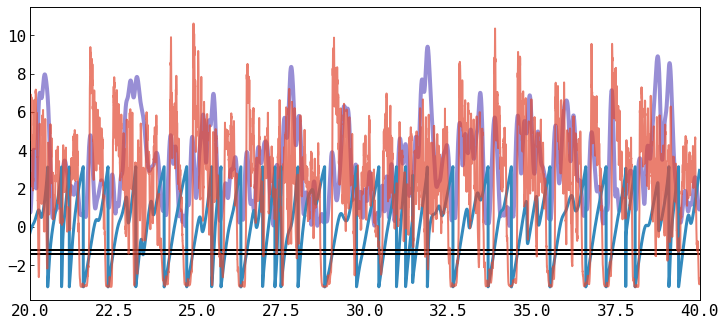

In [34]:
plt.plot(aln_sp_amp.time, aln_sp_amp.data, color="C2", linewidth=4)
plt.plot(aln_so_phase.time, aln_so_phase.data, color="C1", linewidth=3)
plt.axhline(phase_bin_edges[10], 0, 1, color="k")
plt.axhline(phase_bin_edges[11], 0, 1, color="k")

plt.twinx()
plt.plot(aln_sig.time, aln_sig.data, alpha=0.7, color="C0")
# plt.ylim([0.0, 100.0])
plt.yticks([])
plt.xlim([20, 40])